# About

Use the simulated and processed data arrays to create the plots for the manuscript, using data imported from MATLAB.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
from scipy import special
from scipy.spatial import distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import matplotlib.colors as clr
from tqdm.notebook import tqdm
import math
from math import pi


from lib import *

from IPython.display import clear_output

# Directories

In [2]:
foldername = os.path.join(os.getcwd(), 'data', 'arrays', 'ICBM_Matlab', 'trial2')
filename_params = os.path.join(foldername, 'params.mat') # All parameters and raw data
filename_arrays = os.path.join(foldername, 'results.mat') # All plottable arrays

# Import data

### Parameters

In [3]:
dictPar = sio.loadmat(filename_params)

# Raw data
W_raw = dictPar['W_raw']
dist = dictPar['dist']
W = dictPar['W']

# Parameters
N = dictPar['N'][0,0]
vel0 = dictPar['v0']
r0 = np.reshape(dictPar['r0'], -1)
kappa = dictPar['kappa'][0,0]
# gamma0 = dictPar['gamma0'][0,0]
eta = dictPar['eta'][0,0]
numIters = dictPar['numIters'][0,0]

alpha1 = dictPar['alpha1'][0,0]
alpha2 = dictPar['alpha2'][0,0]

# Injury parameters
vel_range = np.reshape(dictPar['vRange'], -1)

# Other
tau0 = dist / vel0
iters = np.arange(numIters)

### Processed arrays

In [4]:
dictArr = sio.loadmat(filename_arrays)

# Stability
eigs = dictArr['eigs']
stab = np.min(eigs.real, axis=0)

# ODE solved rates arrays?

# Objective
objective = np.reshape(dictArr['objective'], -1) # Objective over iters
objMax = dictArr['objMax'][0,0]

# Histograms
gamma0 = dictArr['gamma0']
gammaf = dictArr['gammaf']
tauf = dictArr['tauf']
velf = dictArr['velf']

histtau0 = np.reshape(tau0[W != 0], -1)
histtauf = np.reshape(tauf[W != 0], -1)

histvel0 = np.reshape(vel0[W != 0], -1)
histvelf = np.reshape(velf[W != 0], -1)

# Slopes
slope = dictArr['slope'].T

# Computation time
comp_time = dictArr['comp_time'][0,0]
mode = dictArr['mode']

# Parameters and statistics

## Parameters

In [5]:
var_name1 = ['N', r'Initial velocity range $v_0$ (m/s)', 
            r'Scaling factor $\kappa$', 
            r'Myelination rate $\eta$', 
            r'Baseline firing rate $r_i^0$ (Hz)',
            r'Cost function coefficient',
            r'Cost function exponential coefficient'
            ]

var_value1 = [N, vel_range, kappa, eta, r0[0], alpha1, alpha2]

table1 = pd.DataFrame({'Variable' : var_name1, 'Value': var_value1})

# Display
table1.style

,Variable,Value
0,N,68
1,Initial velocity range $v_0$ (m/s),[0.5 2. ]
2,Scaling factor $\kappa$,0.015
3,Myelination rate $\eta$,0.001
4,Baseline firing rate $r_i^0$ (Hz),100
5,Cost function coefficient,2.94118e-06
6,Cost function exponential coefficient,0.0735294


## Statistics

In [6]:
var_name3 = [r'Number of connections',
             r'Total number of connections',
             r'Mean active connectivity weight',
             r'Initial objective',
             r'Maximum objective reached',
             r'Maximum objective possible',
             r'Total computation time (min)',
             r'Number of iterations', 
             r'Gradient used'
            ]
var_value3 = [np.count_nonzero(W != 0.0), 
              W.size, np.mean(W[W != 0]), 
              objective[0]/1000,
              np.max(objective)/1000,
              objMax/1000,
              comp_time/60,
              numIters,
              mode
             ]


table3 = pd.DataFrame({'Stat' : var_name3, 'Value': var_value3})

# Display
table3.style

,Stat,Value
0,Number of connections,3726
1,Total number of connections,4624
2,Mean active connectivity weight,0.048711
3,Initial objective,355.66
4,Maximum objective reached,367.98
5,Maximum objective possible,368.529
6,Total computation time (min),2.81042
7,Number of iterations,2000
8,Gradient used,['adadelta']


# Figures

## Objective function

(0, 2000)

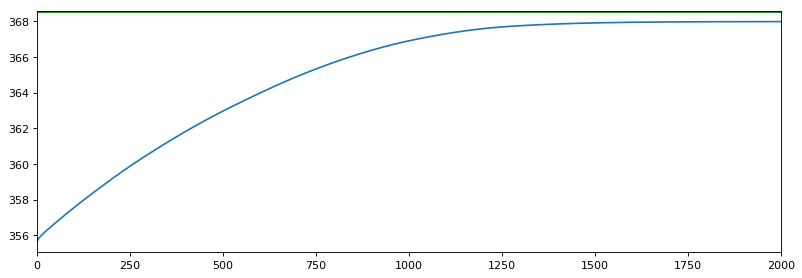

In [7]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(1,numIters+1)
ax.plot(iters, objective/1000)
# ax.axvline(injTime * numIters, color='red', zorder=0)
ax.axhline(y=objMax/1000, color='green', zorder=1)
ax.set_xlim(left=0, right=numIters)

## Connectivity and initial matrices

Left (blue) heatmap of connectivity weights (processed), and right (red) heatmap of initial connection delays.

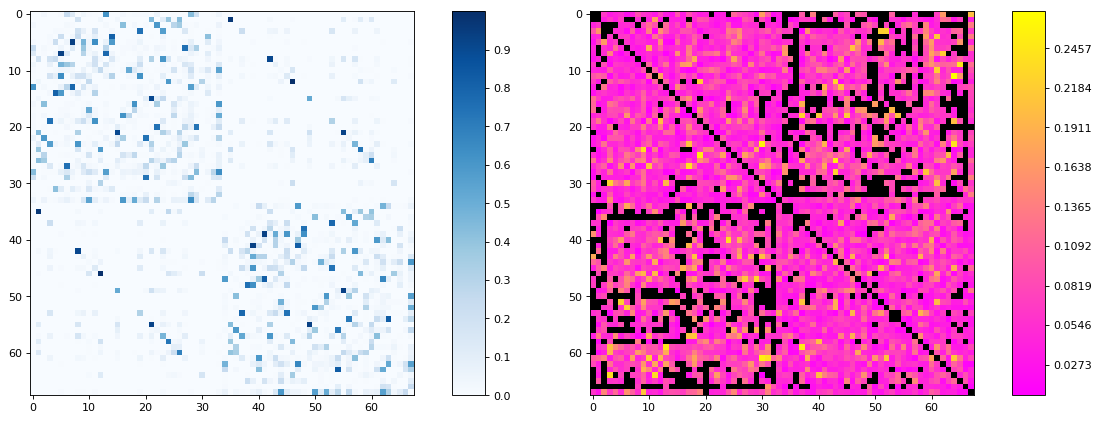

In [8]:
# Positions [left, bottom, width, height] 
bbox0 = [0.05, 0.1, 0.35, 0.80]
bbox1 = [0.43, 0.1, 0.03, 0.80]
bbox2 = [0.55, 0.1, 0.35, 0.80]
bbox3 = [0.93, 0.1, 0.03, 0.80]

tau_matrix =np.ma.masked_where((W == 0), tau0)

fig, ax = plt.subplots(4, figsize=(14,6), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

cs1 = ax[0].imshow(W, cmap='Blues')
ax[2].set_facecolor('black')
cs2 = ax[2].imshow(tau_matrix, cmap='spring',zorder=1)

# Colour bars
numticks1 = 11
numticks2 = 11
ticks1 = np.arange(0, np.max(W), np.round(np.max(W) / numticks1, decimals=1)) # Connectivity strength
ticks2 = np.arange(0, np.max(tau0), np.round(np.max(tau0) / numticks2, decimals=4)) # Delays

fig.colorbar(cs1, cax=ax[1], ticks=ticks1)
fig.colorbar(cs2, cax=ax[3], ticks=ticks2)

## Coincidences over time

Heatmap of coincidence factors at specified timestamps, initially at time = 0s (left), before injury (middle), and post-injury (right).

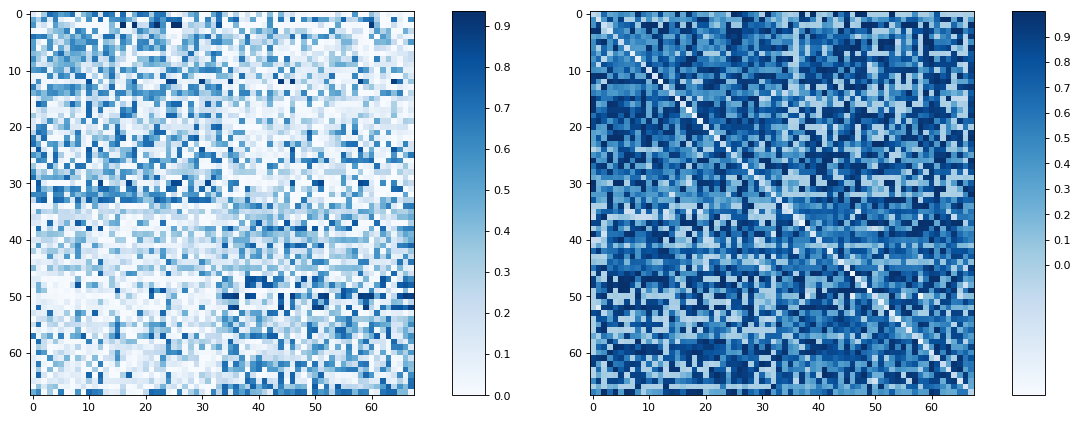

In [9]:
# Positions [left, bottom, width, height] 
bbox0 = [0.05, 0.1, 0.35, 0.80]
bbox1 = [0.43, 0.1, 0.03, 0.80]
bbox2 = [0.55, 0.1, 0.35, 0.80]
bbox3 = [0.93, 0.1, 0.03, 0.80]

fig, ax = plt.subplots(4, figsize=(14,6), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

cs1 = ax[0].imshow(gamma0, cmap='Blues')
cs2 = ax[2].imshow(gammaf-gamma0, cmap='Blues')

# Colour bars
numticks1 = 11
numticks2 = 11
ticks1 = np.linspace(0, 1, numticks1)
ticks2 = np.linspace(0, 1, numticks2)

fig.colorbar(cs1, cax=ax[1], ticks=ticks1)
fig.colorbar(cs2, cax=ax[3], ticks=ticks2)

## Histograms of delays, velocities over time

Histograms of delays, velocities at specfied timestamps, colourcoded.

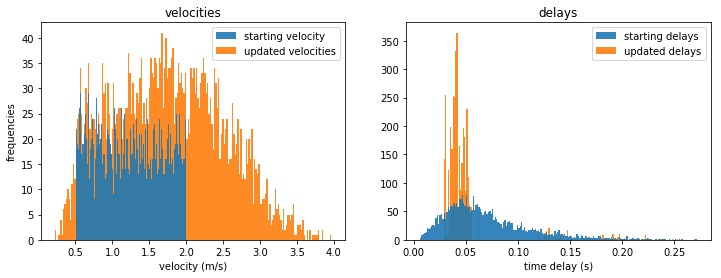

In [10]:
# SETUP
num_bins = 200

# GENERATE FIGURE
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].hist(histvel0, bins=num_bins, alpha=0.9, zorder=1)
axs[0].hist(histvelf, bins=num_bins, alpha=0.9, zorder=0)

axs[1].hist(histtau0, bins=num_bins, alpha=0.9, zorder=2)
axs[1].hist(histtauf, bins=num_bins, alpha=0.9, zorder=0)

axs[0].set_title('velocities')
axs[1].set_title('delays')

axs[0].set_xlabel('velocity (m/s)')
axs[1].set_xlabel('time delay (s)')

axs[0].set_ylabel('frequencies')

axs[0].legend(['starting velocity ', 'updated velocities'])
axs[1].legend(['starting delays ', 'updated delays'])

## Dependence of updated velocities vs. tract lengths

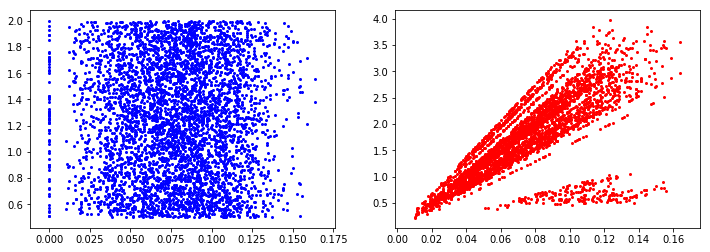

In [23]:
# GENERATE FIGURE
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].scatter(dist, vel0, s=4, color='blue')
axs[1].scatter(dist[W != 0], velf[W != 0], s=4, color='red')

## Sampled slopes

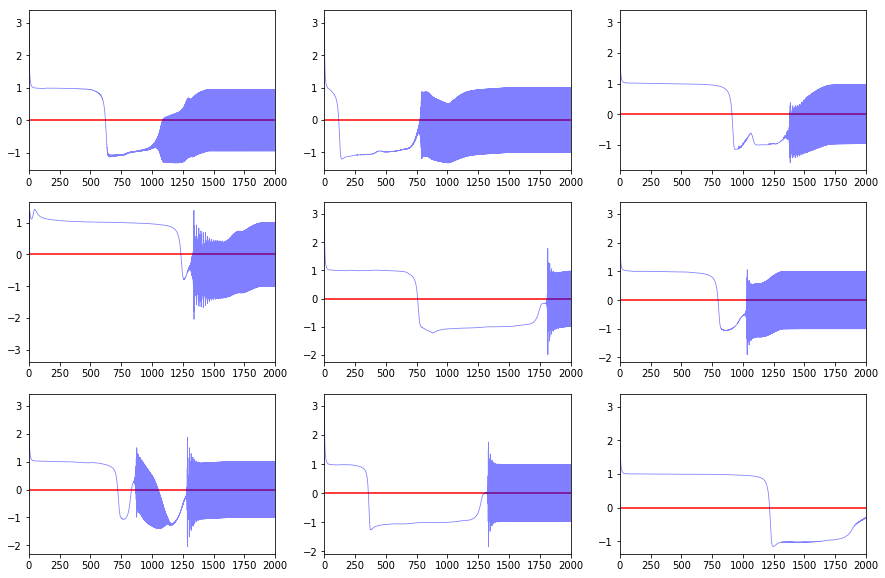

In [12]:
# Options
lw1 = 0.8
alp1 = 0.5

iters = np.arange(1,numIters+1)

inds_sam = np.random.choice(slope.shape[1], size=(3,3), replace=False)
fig, axs = plt.subplots(3,3, figsize=(15,10))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i][j].plot(iters, slope[:,inds_sam[i][j]], linewidth=lw1, alpha=alp1, color='blue')
        axs[i][j].set_xlim(left=0, right=numIters)
        axs[i][j].axhline(y=0, color='red', zorder=0)
        # axs[i][j].axvline(injTime * numIters, color='red', zorder=0)

## Stability analysis

We assess the stability around the equilibrium rates at each iteration, and use an ODE solver to show that the rates converge to their equilibrium following the ODE.

(0, 2000)

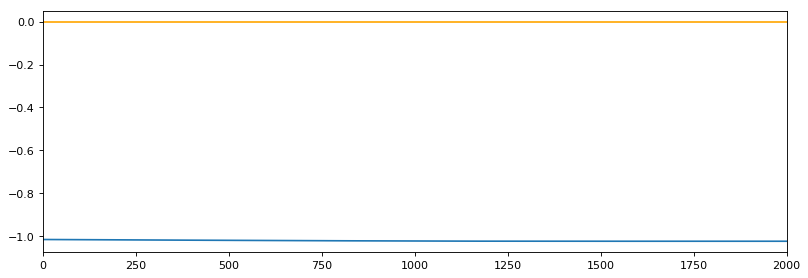

In [13]:
fig, ax = plt.subplots(1, figsize=(12,4), dpi=80)
iters = np.arange(1,numIters+1)
ax.plot(iters, stab)
# ax.axvline(injTime * numIters, color='red', zorder=0)
ax.axhline(y=0, color='orange', zorder=1)
ax.set_xlim(left=0, right=numIters)

### Table 3: Processed statistics

In [14]:
var_name3 = [r'Number of connections',
             r'Total number of connections',
             r'Mean active connectivity weight',
             r'Maximum objective',
             r'Mean final delay',
             r'Mean final velocity']
var_value3 = [np.count_nonzero(W != 0.0), 
              W.size, np.mean(W[W != 0]), 
              np.max(objective), 
              np.mean(histtau3), 
              np.mean(histvel3)]

table3 = pd.DataFrame({'Stat' : var_name3, 'Value': var_value3})

# Display
table3.style

NameError: name 'histtau3' is not defined